In [ ]:
!nvidia-smi

Wed Apr 26 16:23:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python --version
!pip install transformers --quiet
!pip install pytorch-lightning --quiet

Python 3.9.16


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import auroc, accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import KFold

import seaborn as sns        
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

#Import Train / Test Data for Subtask A

In [ ]:
!gdown --id 1bzgtWy451cABr3ON-ZaQ1gpH1V_VFWH1
!gdown --id 1TjVUD5MRPqlAjINhFfRM2vJpB0iaZm6w

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bzgtWy451cABr3ON-ZaQ1gpH1V_VFWH1
To: /content/cleaned_test_data_v1_subtaskA.csv
100% 223k/223k [00:00<00:00, 108MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TjVUD5MRPqlAjINhFfRM2vJpB0iaZm6w
To: /content/cleaned_train_data_v1.csv
100% 2.90M/2.90M [00:00<00:00, 200MB/s]


In [ ]:
df = pd.read_csv("cleaned_test_data_v1_subtaskA.csv")
df.head()

,del,id,tweet,subtask_a,cleaned_tweet
0,0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,whoisq wherestheserver dumpnike declasfisa dem...
1,1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,constitutionday revered conservatives hated pr...
2,2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,foxnews nra maga potus trump 2ndamendment rnc ...
3,3,13876,#Watching #Boomer getting the news that she is...,NOT,watching boomer getting news still parole alwa...
4,4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,nopasaran unity demo oppose far right london a...


In [ ]:
df1 = pd.read_csv("cleaned_train_data_v1.csv")
df1.head()

,del,id,tweet,subtask_a,subtask_b,subtask_c,cleaned_tweet
0,0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,ask native americans take
1,1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,go home drunk maga trump 2020
2,2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon investigating chinese employees selling...
3,3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,someone vetaken piece shit volcano
4,4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,obama wanted liberals illegals move red states


##Data Pre-processing

In [ ]:
df1[df1['cleaned_tweet'].isnull()]

,del,id,tweet,subtask_a,subtask_b,subtask_c,cleaned_tweet
419,419,32122,@USER All of them! 😂😂 URL,NOT,NaN,NaN,NaN
847,847,75079,@USER he is,NOT,NaN,NaN,NaN
995,995,67744,@USER @USER He is.,NOT,NaN,NaN,NaN
1022,1022,62559,@USER she is 😩,NOT,NaN,NaN,NaN
1315,1315,31487,@USER There you are! 👋🐾,NOT,NaN,NaN,NaN
...,...,...,...,...,...,...,...
11679,11679,12502,@USER You are...,NOT,NaN,NaN,NaN
12328,12328,51297,@USER @USER She is a 🤡,OFF,TIN,IND,NaN
12615,12615,19557,"@USER He is.""""",NOT,NaN,NaN,NaN
12872,12872,85713,@USER @USER @USER He is.,NOT,NaN,NaN,NaN


In [ ]:
# select columns of interest
ATrainData = df1[["cleaned_tweet", "subtask_a"]]
ATrainData = ATrainData[ATrainData['cleaned_tweet'].notna()]

#convert to one hot encoding: 1 if Offensive, 0 otherwise
ATrainData['subtask_a'] = ATrainData['subtask_a'].apply(lambda x: 1 if x=='OFF' else 0)
ATrainData.head()

,cleaned_tweet,subtask_a
0,ask native americans take,1
1,go home drunk maga trump 2020,1
2,amazon investigating chinese employees selling...,0
3,someone vetaken piece shit volcano,1
4,obama wanted liberals illegals move red states,0


[4396, 8774]


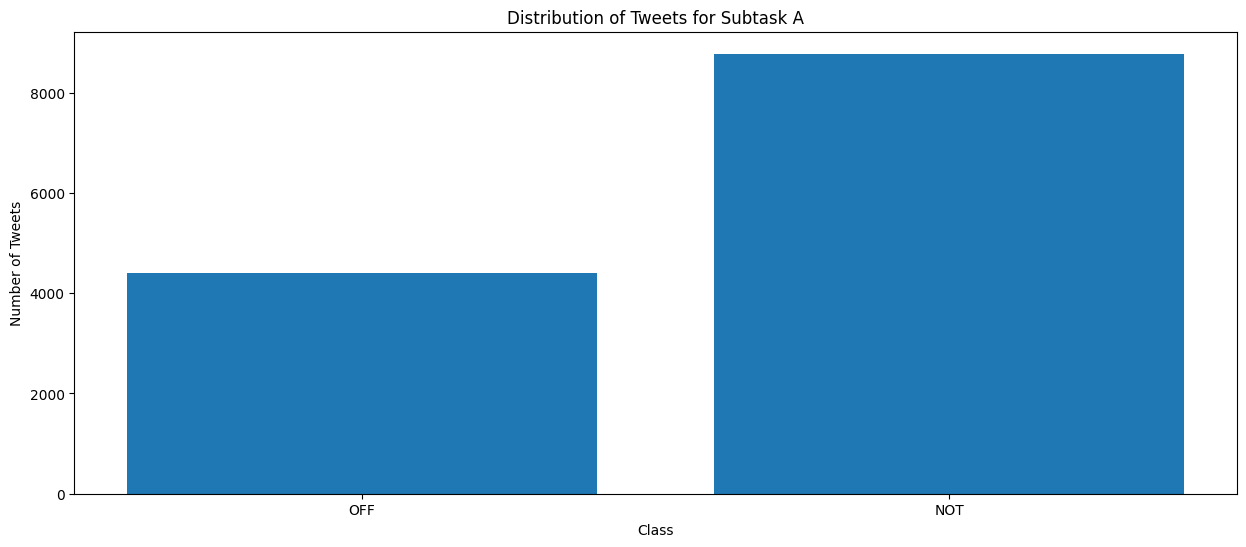

In [ ]:
A_LABELS = ["OFF", "NOT"]
fig = plt.figure(figsize=(15, 6))
y = [(ATrainData['subtask_a'] == label).sum() for label in ATrainData["subtask_a"].unique().tolist()]
print(y)
plt.bar(A_LABELS, y)
plt.xlabel("Class")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweets for Subtask A")
plt.show()

We have almost double the number of NOT offensive tweets than OFF tweets. This means that we will have to perform *undersampling*.

In [ ]:
numOfOFFTweets = (ATrainData['subtask_a'] == 1).sum()
numOfOFFTweets

4396

In [ ]:
NOTtweets = ATrainData.loc[ATrainData['subtask_a'] == 0]
NOTtweets.shape

(8774, 2)

Randomly Sample NOT offensive Tweets 4400 times to undersample our dataset

In [ ]:
sampleNOT = NOTtweets.sample(n=numOfOFFTweets, random_state=1)
print(sampleNOT.shape)

(4396, 2)


In [ ]:
offensiveTweets = ATrainData.loc[ATrainData['subtask_a'] == 1]
train_df = pd.concat([offensiveTweets, sampleNOT])
print(train_df.shape)

(8792, 2)


[4396, 4396]


Text(0.5, 1.0, 'Distribution of Tweets for Subtask A')

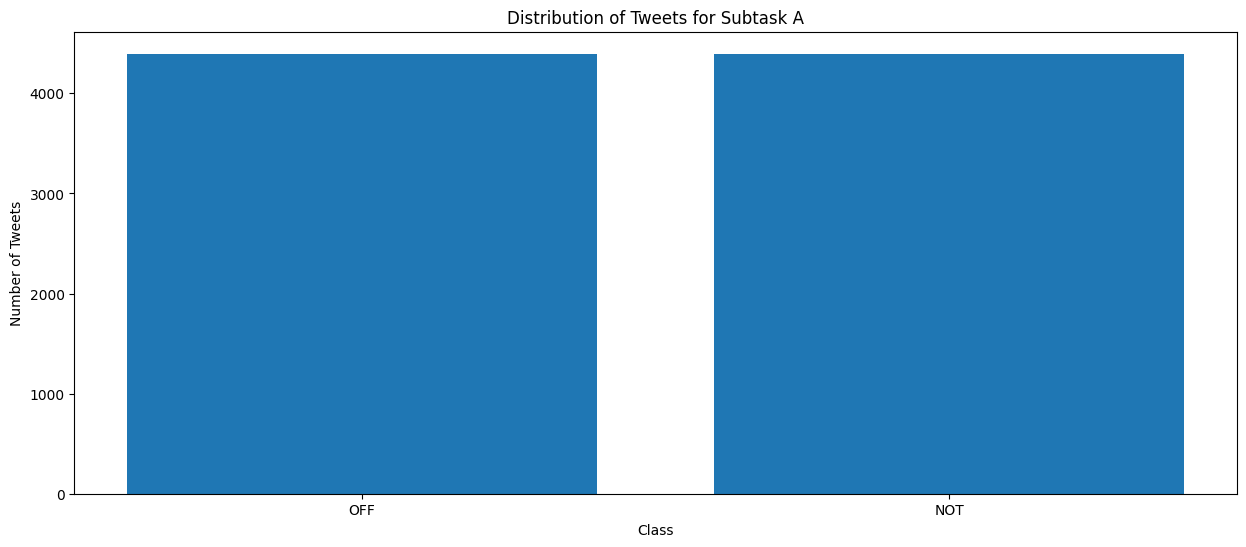

In [ ]:
A_LABELS = ["OFF", "NOT"]
fig = plt.figure(figsize=(15, 6))
y = [(train_df['subtask_a'] == label).sum() for label in train_df["subtask_a"].unique().tolist()]
print(y)
plt.bar(A_LABELS, y)
plt.xlabel("Class")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweets for Subtask A")

The two classes are now balanced.

##Prepare Validation Test Set

In [ ]:
#select columns of interest
val_df = df[['cleaned_tweet', 'subtask_a']]
val_df = val_df[val_df['cleaned_tweet'].notna()]

#convert to one hot encoding: 1 if Offensive, 0 otherwise
val_df['subtask_a'] = val_df['subtask_a'].apply(lambda x: 1 if x=='OFF' else 0)
val_df.head()

,cleaned_tweet,subtask_a
0,whoisq wherestheserver dumpnike declasfisa dem...,1
1,constitutionday revered conservatives hated pr...,0
2,foxnews nra maga potus trump 2ndamendment rnc ...,0
3,watching boomer getting news still parole alwa...,0
4,nopasaran unity demo oppose far right london a...,1


#Tokenizer

In [ ]:
# load pretrained tokenizer
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  count = len(tokenizer.encode(
    row['cleaned_tweet'], 
    max_length=512, 
    truncation=True))
  token_counts.append(count)  

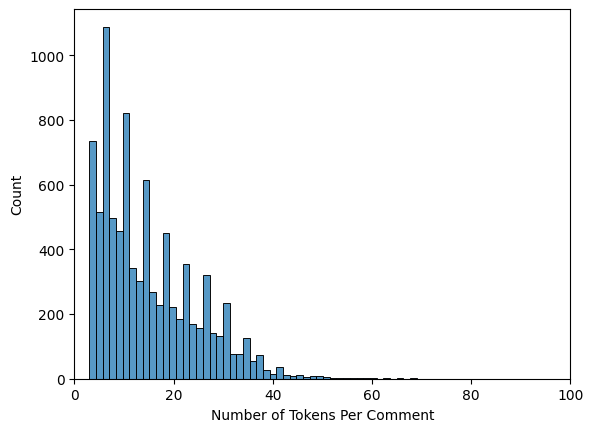

In [ ]:
sns.histplot(token_counts)
plt.xlabel("Number of Tokens Per Comment")
plt.xlim([0, 100]);

All the tweets can be encoded using 80 tokens, therefore we
Set MAX_TOKEN_COUNT = 80


In [ ]:
MAX_TOKEN_COUNT = 80

#PyTorch Dataset

In [ ]:
class TweetDataset(Dataset):
  def __init__(self, data: pd.DataFrame, tokenizer: AutoTokenizer, max_token_len: int=128):
    self.data = data
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)
  
  # return encoding of review
  def __getitem__ (self, index: int):
    data_row = self.data.iloc[index]
    tweet = data_row['cleaned_tweet']
    label = data_row['subtask_a']
    encoding = self.tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )

    return dict(
        tweet=tweet,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        label=torch.FloatTensor([label])
    )    

Set up PyTorch DataModule

The final step is to wrap our dataset into a lightningDataModule

In [ ]:
class TweetDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  # create dataset for each of the training and test sets
  def setup(self, stage=None):
    self.train_dataset = TweetDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )
    self.test_dataset = TweetDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=4
    )
    
  # make predictions on a single example (single batch size)
  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=4
    )
  
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=4
    )

#Build Model

In [ ]:
from torch.optim import lr_scheduler
class OffensiveTweetTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    # classifier: serve as a way to get the output of the BERT model and convert those into the num of classes which we want to predict
    self.classifier1 = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.dropOutLayer = nn.Dropout(p=0.1)
    self.relu = nn.ReLU()
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.classifier2 = nn.Linear(2, 1)
    # This criterion computes the cross entropy loss between input logits and target
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    # model architecture
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier1(output.pooler_output)
    output = self.relu(output)
    output = self.dropOutLayer(output)
    output = self.classifier2(output)
    # apply sigmoid function
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  
  def test_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  # configer optimisers and learning rate scheduler
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=5e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=self.n_warmup_steps,
        num_training_steps=self.n_training_steps
    )
    # return a list of optimisers and schedulers
    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
        )
    )

We simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to number of training examples / batch size. The number of total training steps is training steps per epoch * number of epochs:

#Train Model with 10-Fold Cross Validation

In [ ]:
train_df

,cleaned_tweet,subtask_a
0,ask native americans take,1
1,go home drunk maga trump 2020,1
3,someone vetaken piece shit volcano,1
5,liberals kookoo,1
6,oh noes tough shit,1
...,...,...
5460,loyal maga followers need read,0
9400,one cares,0
6675,pretend care women attacking conservatives cou...,0
8270,kirk douglas,0


Load Model

In [ ]:
# Hyperparameters
N_EPOCHS = 5
BATCH_SIZE = 16
MAX_TOKEN_COUNT = 80

BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

accuracies = []

kFold = KFold(n_splits=10, shuffle=True)
for fold_number, (train_index, test_index) in enumerate(kFold.split(train_df)):
  train_df_fold = train_df.iloc[train_index]
  val_df_fold = train_df.iloc[test_index]

  data_module = TweetDataModule(
      train_df_fold,
      val_df_fold,
      tokenizer,
      batch_size=BATCH_SIZE,
      max_token_len=MAX_TOKEN_COUNT
  )

  steps_per_epoch = len(train_df_fold) // BATCH_SIZE
  total_training_steps = steps_per_epoch * N_EPOCHS
  warmup_steps = total_training_steps // 5

  model = OffensiveTweetTagger(
    n_classes=len(A_LABELS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
  )
  
  # Run on GPU
  model.cuda()

  checkpoint_callback = ModelCheckpoint(
    dirpath="subtask_A/Fold-{0}".format(fold_number),
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True
  )

  early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

  trainer = pl.Trainer(
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=N_EPOCHS
  )

  trainer.fit(model, data_module)
  trainer.test(model, data_module)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  val_dataset = TweetDataset(
    val_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
  )

  predictions = []
  labels = []

  # calculate predictions of model 
  with torch.no_grad(): 
    for item in tqdm(val_dataset):
      input_ids = item["input_ids"].unsqueeze(dim=0)
      attention_mask = item["attention_mask"].unsqueeze(dim=0)
      input_ids.to(device)
      attention_mask.to(device)
      _, prediction = model(
        input_ids,
        attention_mask
      )
      predictions.append(prediction.flatten())
      labels.append(item["label"].int())

    predictions = torch.stack(predictions).detach().cpu()
    labels = torch.stack(labels).detach().cpu()

    # store accuracy of each fold
    fold_accuracy = accuracy(task="binary", preds=predictions, target=labels)
    print("fold-{0}: accuracy: {1}".format(fold_number, fold_accuracy))
    accuracies.append(fold_accuracy)
  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 445: 'val_loss' reached 0.52722 (best 0.52722), saving model to '/content/subtask_A/Fold-0/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 890: 'val_loss' reached 0.50645 (best 0.50645), saving model to '/content/subtask_A/Fold-0/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1335: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1780: 'val_loss' was not in top 1
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.625357985496521     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/860 [00:00<?, ?it/s]

fold-0: accuracy: 0.775581419467926


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 445: 'val_loss' reached 0.55979 (best 0.55979), saving model to '/content/subtask_A/Fold-1/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 890: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1335: 'val_loss' was not in top 1
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5878679752349854     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/860 [00:00<?, ?it/s]

fold-1: accuracy: 0.7430232763290405


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 446: 'val_loss' reached 0.58687 (best 0.58687), saving model to '/content/subtask_A/Fold-2/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 892: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1338: 'val_loss' reached 0.57098 (best 0.57098), saving model to '/content/subtask_A/Fold-2/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1784: 'val_loss' reached 0.50598 (best 0.50598), saving model to '/content/subtask_A/Fold-2/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2230: 'val_loss' reached 0.49317 (best 0.49317), saving model to '/content/subtask_A/Fold-2/best-checkpoint-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.49316853284835815    │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/860 [00:00<?, ?it/s]

fold-2: accuracy: 0.7162790894508362


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 446: 'val_loss' reached 0.63031 (best 0.63031), saving model to '/content/subtask_A/Fold-3/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 892: 'val_loss' reached 0.48538 (best 0.48538), saving model to '/content/subtask_A/Fold-3/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1338: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1784: 'val_loss' was not in top 1
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5460039377212524     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/860 [00:00<?, ?it/s]

fold-3: accuracy: 0.775581419467926


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 446: 'val_loss' reached 0.54728 (best 0.54728), saving model to '/content/subtask_A/Fold-4/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 892: 'val_loss' reached 0.50349 (best 0.50349), saving model to '/content/subtask_A/Fold-4/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1338: 'val_loss' reached 0.47655 (best 0.47655), saving model to '/content/subtask_A/Fold-4/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1784: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2230: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5999767184257507     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/860 [00:00<?, ?it/s]

fold-4: accuracy: 0.7767441868782043


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 446: 'val_loss' reached 0.60138 (best 0.60138), saving model to '/content/subtask_A/Fold-5/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 892: 'val_loss' reached 0.53630 (best 0.53630), saving model to '/content/subtask_A/Fold-5/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1338: 'val_loss' reached 0.53209 (best 0.53209), saving model to '/content/subtask_A/Fold-5/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1784: 'val_loss' reached 0.52471 (best 0.52471), saving model to '/content/subtask_A/Fold-5/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2230: 'val_loss' reached 0.51219 (best 0.51219), saving model to '/content/subtask_A/Fold-5/best-checkpoint.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5121890306472778     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/860 [00:00<?, ?it/s]

fold-5: accuracy: 0.7465116381645203


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 446: 'val_loss' reached 0.67972 (best 0.67972), saving model to '/content/subtask_A/Fold-6/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 892: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1338: 'val_loss' was not in top 1
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6930609345436096     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/860 [00:00<?, ?it/s]

fold-6: accuracy: 0.27906978130340576


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 446: 'val_loss' reached 0.75126 (best 0.75126), saving model to '/content/subtask_A/Fold-7/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 892: 'val_loss' reached 0.74884 (best 0.74884), saving model to '/content/subtask_A/Fold-7/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1338: 'val_loss' reached 0.74714 (best 0.74714), saving model to '/content/subtask_A/Fold-7/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1784: 'val_loss' reached 0.74613 (best 0.74613), saving model to '/content/subtask_A/Fold-7/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2230: 'val_loss' reached 0.74580 (best 0.74580), saving model to '/content/subtask_A/Fold-7/best-checkpoint.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.7457982301712036     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/860 [00:00<?, ?it/s]

fold-7: accuracy: 0.7209302186965942


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 446: 'val_loss' reached 0.71560 (best 0.71560), saving model to '/content/subtask_A/Fold-8/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 892: 'val_loss' reached 0.71442 (best 0.71442), saving model to '/content/subtask_A/Fold-8/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1338: 'val_loss' reached 0.71361 (best 0.71361), saving model to '/content/subtask_A/Fold-8/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1784: 'val_loss' reached 0.71316 (best 0.71316), saving model to '/content/subtask_A/Fold-8/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2230: 'val_loss' reached 0.71300 (best 0.71300), saving model to '/content/subtask_A/Fold-8/best-checkpoint.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.7129979729652405     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/860 [00:00<?, ?it/s]

fold-8: accuracy: 0.27906978130340576


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 446: 'val_loss' reached 0.57534 (best 0.57534), saving model to '/content/subtask_A/Fold-9/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 892: 'val_loss' reached 0.53103 (best 0.53103), saving model to '/content/subtask_A/Fold-9/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1338: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1784: 'val_loss' was not in top 1
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6774687170982361     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/860 [00:00<?, ?it/s]

fold-9: accuracy: 0.7720929980278015


In [ ]:
accuracies = np.array(accuracies)
print(accuracies)
np.mean(accuracies)

[0.7755814  0.7430233  0.7162791  0.7755814  0.7767442  0.74651164
 0.27906978 0.7209302  0.27906978 0.772093  ]


0.6584884

In [ ]:
# Claculate average accuracy 
accuracy = accuracy(task="binary", preds=predictions, target=labels)
print("accuracy: {0}".format(accuracy))

accuracy: 0.7732558250427246


In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(classification_report(
  y_true,
  y_pred,
  target_names=A_LABELS,
  zero_division=0
))

              precision    recall  f1-score   support

         OFF       0.89      0.80      0.84       620
         NOT       0.58      0.73      0.65       240

    accuracy                           0.78       860
   macro avg       0.74      0.77      0.75       860
weighted avg       0.80      0.78      0.79       860



##Plot Graph to Show Accuracy Over Each Fold

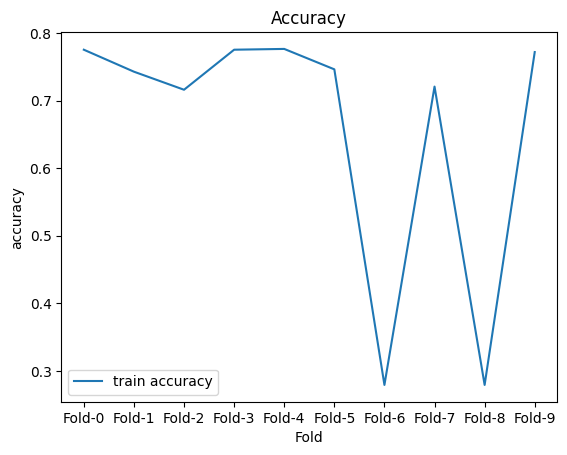

In [ ]:
plt.plot(["Fold-0", "Fold-1", "Fold-2", "Fold-3", "Fold-4",
          "Fold-5", "Fold-6", "Fold-7", "Fold-8", "Fold-9"], accuracies)

plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Fold')
plt.legend(['train accuracy'], loc='lower left')
plt.show()

Fold-4 Produced the highest Accuracy, with the average accuracy of 0.67 across all 10 Folds.

#Train Model using 80%-20% train-test split

In [ ]:
# Hyperparameters
N_EPOCHS = 4
BATCH_SIZE = 16
MAX_TOKEN_COUNT = 80

BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

train_df_fold, val_df_fold = train_test_split(train_df, test_size=0.20)

data_module = TweetDataModule(
    train_df_fold,
    val_df_fold,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

steps_per_epoch = len(train_df_fold) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5

model = OffensiveTweetTagger(
  n_classes=len(A_LABELS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

# Run on GPU
model.cuda()

checkpoint_callback = ModelCheckpoint(
  dirpath="subtask_A/train_test_split",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min",
  save_weights_only=True
)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

trainer = pl.Trainer(
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS
)

trainer.fit(model, data_module)
trainer.test(model, data_module)
  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 440: 'val_loss' reached 0.65616 (best 0.65616), saving model to '/content/subtask_A/train_test_split/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 880: 'val_loss' reached 0.63044 (best 0.63044), saving model to '/content/subtask_A/train_test_split/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1320: 'val_loss' reached 0.57952 (best 0.57952), saving model to '/content/subtask_A/train_test_split/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1760: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5923641324043274     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5923641324043274}]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

val_dataset = TweetDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

with torch.no_grad(): 
  for item in tqdm(val_dataset):
    input_ids = item["input_ids"].unsqueeze(dim=0)
    attention_mask = item["attention_mask"].unsqueeze(dim=0)
    input_ids.to(device)
    attention_mask.to(device)
    _, prediction = model(
      input_ids,
      attention_mask
    )
    predictions.append(prediction.flatten())
    labels.append(item["label"].int())

  predictions = torch.stack(predictions).detach().cpu()
  labels = torch.stack(labels).detach().cpu()


  0%|          | 0/860 [00:00<?, ?it/s]

In [ ]:
# output accuracy
model_accuracy = accuracy(task="binary", preds=predictions, target=labels)
print("Accuracy: ", model_accuracy)

Accuracy:  tensor(0.7593)


In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(classification_report(
  y_true,
  y_pred,
  target_names=A_LABELS,
  zero_division=0
))

              precision    recall  f1-score   support

         OFF       0.92      0.73      0.81       620
         NOT       0.54      0.84      0.66       240

    accuracy                           0.76       860
   macro avg       0.73      0.78      0.74       860
weighted avg       0.82      0.76      0.77       860



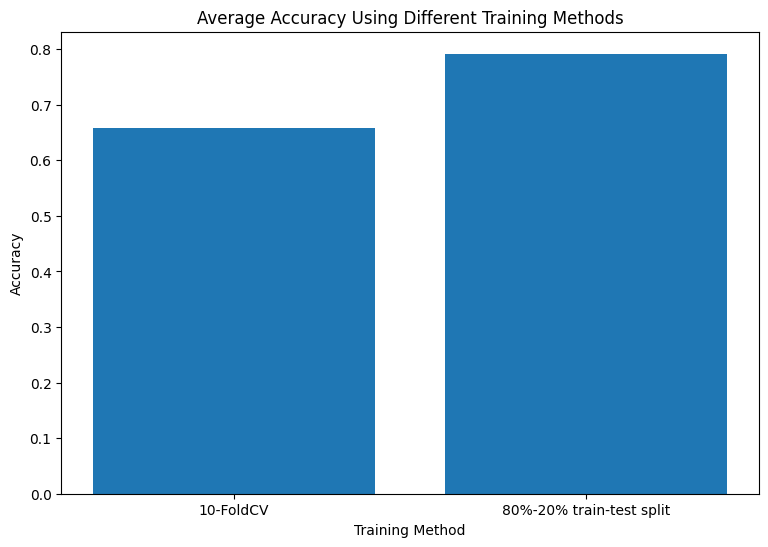

In [ ]:
x_LABELS = ["10-FoldCV", "80%-20% train-test split"]
# CLASS_LABELS
fig = plt.figure(figsize=(9, 6))
y = [0.6584884, 0.7919]

plt.bar(x_LABELS, y)
plt.xlabel("Training Method")
plt.ylabel("Accuracy")
plt.title("Average Accuracy Using Different Training Methods")
plt.show()

On average a single fold performed better than any Fold. Therefore, when training the next two models we will only carry out training using a 80%-20% train-test split. This will also save a lot of time training.

# Load in Saved Model

In [ ]:
trained_model = OffensiveTweetTagger.load_from_checkpoint(
  "/content/subtask_A/train_test_split/best-checkpoint.ckpt",
  n_classes=len(A_LABELS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# trained_model = model.to(device)

val_dataset = TweetDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

with torch.no_grad(): 
  for item in tqdm(val_dataset):
    input_ids = item["input_ids"].unsqueeze(dim=0)
    attention_mask = item["attention_mask"].unsqueeze(dim=0)
    input_ids.to(device)
    attention_mask.to(device)
    _, prediction = model(
      input_ids,
      attention_mask
    )
    predictions.append(prediction.flatten())
    labels.append(item["label"].int())

  predictions = torch.stack(predictions).detach().cpu()
  labels = torch.stack(labels).detach().cpu()


  0%|          | 0/860 [00:00<?, ?it/s]

## Predicting unseen tweet using the trained model

In [ ]:
test_tweet= "#FortniteBattleRoyale #XboxShare @USER   Please ban this cheating scum.  he is literally invisible URL"

THRESHOLD = 0.5

encoding = tokenizer.encode_plus(
    test_tweet,
    add_special_tokens=True,
    max_length=400,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
)

trained_model.to('cpu')
encoding.to('cpu')

_, test_prediction = trained_model(encoding['input_ids'], encoding['attention_mask'])
# test_prediction = torch.stack(predictions).detach().cpu()
test_prediction = test_prediction.flatten().numpy()


In [ ]:
print("Tweet: ", test_tweet)
if(test_prediction[0] > 0.5):
  print("Result: This tweet is OFFENSIVE")
else:
  print("Result: This tweet is NOT OFFENSIVE")

Tweet:  #FortniteBattleRoyale #XboxShare @USER   Please ban this cheating scum.  he is literally invisible URL
Result: This tweet is OFFENSIVE
